# Network of networks

Networks where created, this networks have topologies and functions. The topological and dynamic distance was compared.

Each network has a name that corresponds to: 
* MOTIF: motif of network
* ID, ID: parameter of order
* MODEL: Number of model/function

Only comparisons between different networks where taken into account.

In [1]:
# Import
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

Load data. The data is a list of edges with topological and dynamical distance.

In [2]:
# Load data
data = np.genfromtxt('distancias3nodos.csv', delimiter=',', dtype=np.int32)
# remove header
data = np.delete(data, 0, 0)

We will add a motif edge index and a color
1. m1-m1 blue
2. m1-m2 'cyan'
3. m1-m3 'DeepPink'
4. m1-m4 'magenta'
5. m2-m2 'green'
6. m2-m3 'Brown'
7. m2-m4 'Olive'
8. m3-m3 'Orange'
9. m3-m4 'OrangeRed'
10. m4-m4 'red'


In [3]:
def edges2index( data ):
    index = [str(d[0]) + str(d[1]) for d in data ]
    index = [d[0]+d[4]+d[1]+d[5]+d[2]+d[6]+d[3]+d[7] for d in index ]
    index = [int(d) for d in index]
    return index

def edges2motifcolor( data ):
    color = []
    for d in data:
        i = int(str(d[0])[0] + str(d[1])[0])
        if i == 11: color.append('blue')
        if i == 12: color.append('cyan')
        if i == 13: color.append('deeppink')
        if i == 14: color.append('m')
        if i == 22: color.append('green')
        if i == 23: color.append('brown')
        if i == 24: color.append('olive')
        if i == 33: color.append('orange')
        if i == 34: color.append('orangered')
        if i == 44: color.append('r')
    return color

## Distance distribution

Distribution of topological distances

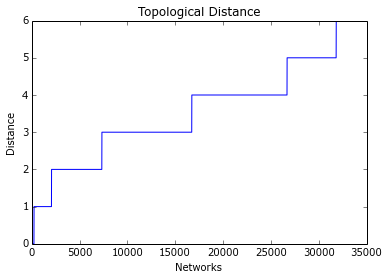

In [4]:
d_top = data[:,2]
plt.plot(sorted(d_top), 'b')
plt.xlabel('Networks')
plt.ylabel('Distance')
plt.title('Topological Distance')
plt.show()

Distribution of dynamic distances

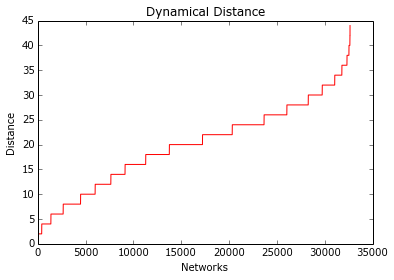

In [5]:
d_dyn = data[:,3]
plt.xlabel('Networks')
plt.ylabel('Distance')
plt.title('Dynamical Distance')
plt.plot(sorted(d_dyn), 'r') #All distances

plt.show()

* Does it follows a distribution?

Separate by topological distance

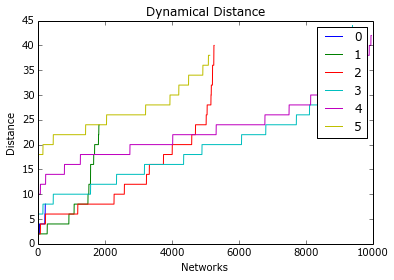

In [34]:
for i in range(0, max(data[:,2])): #sort by topological distance
    data_i = data[data[:,2]==i]
    d_dyn_i = data_i[:,3]
    plt.plot(sorted(d_dyn_i), label=str(i))
plt.xlabel('Networks')
plt.ylabel('Distance')
plt.title('Dynamical Distance')
plt.legend()

plt.show()

Topological vs dynamic distances

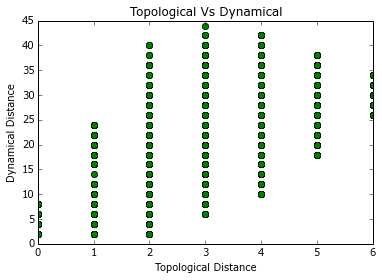

In [6]:
plt.plot(d_top, d_dyn, 'go')
plt.xlabel('Topological Distance')
plt.ylabel('Dynamical Distance')
plt.title('Topological Vs Dynamical')
plt.show()

This is confusing, maybe add a third axis and sort in a better way...

We'll plot by index, intercalating the numbers, so 1001-1021 -> 11000211

/usr/lib/python3/dist-packages/matplotlib/collections.py:549: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


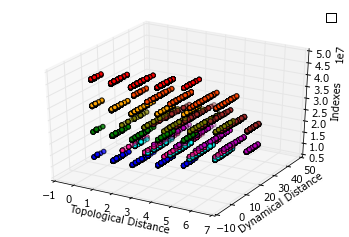

In [8]:
from mpl_toolkits.mplot3d import Axes3D

index = edges2index(data)
color = edges2motifcolor(data)

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(d_top, d_dyn, index, c=color)
ax.legend('Distances by index')
ax.set_xlabel('Topological Distance')
ax.set_ylabel('Dynamical Distance')
ax.set_zlabel('Indexes')

plt.show()

Well... Comparisons between same motifs have smaller distances... the rest is a disaster.

Lets filter to obtain only the edges with topological distance 0

/usr/lib/python3/dist-packages/matplotlib/collections.py:549: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


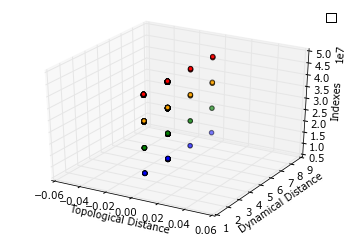

In [26]:
data0 = data[data[:,2]==0]

index0 = edges2index(data0)
color0 = edges2motifcolor(data0)

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(data0[:,2], data0[:,3], index0, c=color0)
ax.legend('D_top 0 by index')
ax.set_xlabel('Topological Distance')
ax.set_ylabel('Dynamical Distance')
ax.set_zlabel('Indexes')

plt.show()

Edges with topological distance 1

/usr/lib/python3/dist-packages/matplotlib/collections.py:549: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


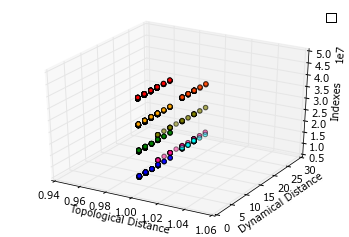

In [27]:
data1 = data[data[:,2]==1]

index1 = edges2index(data1)
color1 = edges2motifcolor(data1)

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(data1[:,2], data1[:,3], index1, c=color1)
ax.legend('D_top 1 by index')
ax.set_xlabel('Topological Distance')
ax.set_ylabel('Dynamical Distance')
ax.set_zlabel('Indexes')

plt.show()

## Dendogram